In [1]:
import os
import coastalcf as clf
from esa_snappy import ProductIO, GPF
from esa_snappy import GPF, HashMap, jpy
import numpy as np

---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
//////////////////        PREPARACIÓN DE LOS DATOS        /////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [2]:
# --- 1. Define la región de interés (ROI) para el subconjunto y la ruta del producto.
# Si no existew substet colocar None
# x = y = width = height = None
#Inicio de la región de interés (ROI) en coordenadas de píxeles.
x=32
y = 14091
#Final de la región de interés (ROI) en coordenadas de píxeles.
width = 1355
height = 897
#x = y = width = height = None

# Defininir parámetros para el operador GLCM.
para = {'sourceBands': 'VH'}

# Path del Producto de Sentinel 1 y ouput de archivos.

sentinel_1_path = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909'
sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)
output_directory = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio'
output_directorysh = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\shape'


---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
///////////////// APLICACIÓN DE LOS PASOS DE PROCESAMIENTO ////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [3]:
# --- 1. Lectura de metadatos del producto Sentinel-1 ---
product = clf.readMetadata(sentinel_1_path, toPrint=True)  

# --- 2. Eliminación de ruido térmico : do_thermal_noise_removal [output]---
thermaremoved = clf.do_thermal_noise_removal(product)
if thermaremoved is None:
    raise RuntimeError("Thermal noise removal failed.")
print(f"Bands after ThermalNoiseRemoval: {list(thermaremoved.getBandNames())}")
#**************************************************************************
# --- 3. Calibración radiométrica : radiometricCalibration [calibrated] ---
calibrate = clf.radiometricCalibration(thermaremoved)
if calibrate is None:
    raise RuntimeError("Radiometric calibration failed.")
print(f"Bands after RadiometricCalibration: {list(calibrate.getBandNames())}")

# - Verificar las bandas después de la calibración
valid_bands = list(calibrate.getBandNames())
print(f" Bandas disponibles después de la calibración: {valid_bands}")

# - Asegurar que usamos solo las bandas que existen
subset_bands = [band for band in ['Sigma0_VH', 'Sigma0_VV', 'Beta0_VH', 'Beta0_VV'] if band in valid_bands]
if not subset_bands:
    raise RuntimeError("No existen Bandas válidas para el subset.")
# ---
# --- Paso 3.1: Crear el subset después de calibrar ---

subset_product = clf.subset(calibrate, x, y, width, height, subset_bands)

# - Validar subset antes de continuar
if subset_product is None or subset_product.getSceneRasterWidth() == 0 or subset_product.getSceneRasterHeight() == 0:
    raise RuntimeError("Error: El subset no contiene datos válidos.")

print(f" Subset creado correctamente con bandas: {list(subset_product.getBandNames())}")
print(subset_product.getMetadataRoot().toString())
#**************************************************************************
# --- 4. Aplicación de multilooking : perform_multilook [multilook]
print("Performing multilooking...")
#multilook = perform_multilook(calibrate)
multilook = clf.perform_multilook(subset_product)
if multilook is None:
    raise RuntimeError("Multilooking failed.")
#**************************************************************************
# --- 5. Filtrado de speckle : speckleFiltering [speckle]
print("Applying speckle filtering...")
speckle = clf.speckleFiltering(multilook, toPrint=True)
if speckle is None:
    raise RuntimeError("Speckle filtering failed.")


#**************************************************************************
# --- 6. Nivelación del terreno (Terrain Flattening) : perform_terrain_flattening [terrain]
print("Applying terrain flattening...")
terrain1 = clf.perform_terrain_flattening(speckle)
if terrain1 is None:
    raise RuntimeError("Terrain flattening failed.")

# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "terrain1")
#ProductIO.writeProduct(terrain1, output_path_terrain, "GeoTIFF")
#******************x********************************************************
# --- 7. Cálculo de texturas GLCM : glcmOp / glcm [textura]
print("Calculating texture...")
textura = clf.glcmOp().glcm(terrain1, para)
if textura is None:
    raise RuntimeError("GLCM texture calculation failed.")
# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "glcm")
glcmc = clf.geometricCorrection(textura, toPrint=True)
#ProductIO.writeProduct(glcmc, output_path_terrain, "GeoTIFF")
#!!!!!!!!!!!!!!!!!!!!!
#**************************************************************************


Producto: S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909, 25999 x 16717 píxeles
Bandas:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
	Eliminando ruido térmico...
Bands after ThermalNoiseRemoval: ['Intensity_VH', 'Intensity_VV']
	Aplicando calibración radiométrica...
Bands after RadiometricCalibration: ['Sigma0_VH', 'Beta0_VH']
 Bandas disponibles después de la calibración: ['Sigma0_VH', 'Beta0_VH']
Bandas en el subset: ['Sigma0_VH', 'Beta0_VH']
 Subset creado correctamente con bandas: ['Sigma0_VH', 'Beta0_VH']
org.esa.snap.core.datamodel.MetadataElement[name=metadata]
Performing multilooking...
	Aplicando Multilooking: RgLooks=1, AzLooks=1, Pixel=10m, Intensidad=False
Applying speckle filtering...
	Bandas del producto filtrado: ['Sigma0_VH', 'Beta0_VH']
Applying terrain flattening...
	Aplicando nivelación del terreno...
Calculating texture...
GLCM: Estableciendo parámetros...
GLCM: Creando producto GLCM...
org.esa.snap.core.datamodel.Product[n

Performing water detection...

--- Iniciando detección de agua con TODOS los métodos ---
Bandas disponibles: ['Gamma0_VH_GLCMMean']
Rango de datos lineales: -9999.0 254.0
Rango de datos lineales: -9999.0 254.0
Convirtiendo a escala de decibeles (dB)...
Conversión a dB completada.
Rango de valores en dB: Min=-0.00, Max=24.05
Calculando umbrales (Otsu, Niblack, Sauvola, Li)...


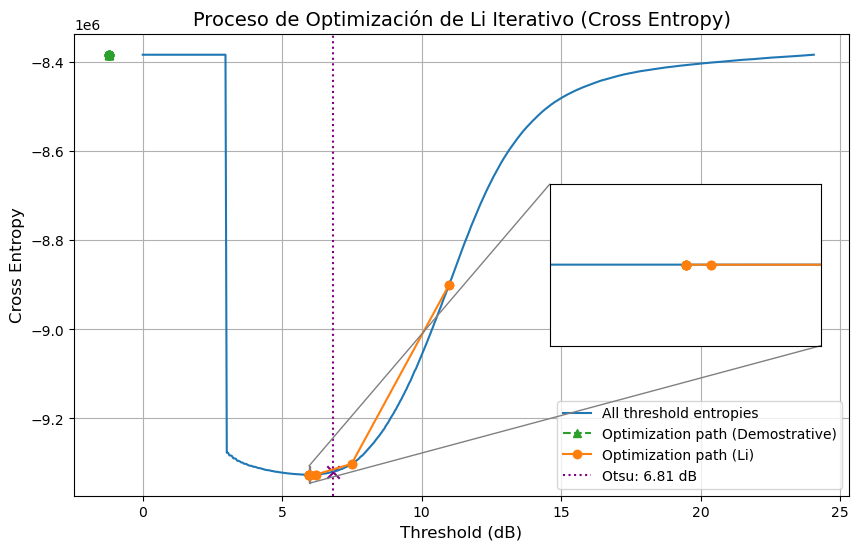

Threshold inicial de Li: 5.9677734375
Threshold optimizado de Li Iterativo: 5.9677734375
  - Otsu         = 6.811
  - Niblack      = 4.432
  - Sauvola      = 4.694
  - Li           = 5.968
  - Li iterativo = 5.968
Creando producto individual para: flood_otsu
Producto creado: flood_otsu
Creando producto individual para: flood_niblack
Producto creado: flood_niblack
Creando producto individual para: flood_sauvola
Producto creado: flood_sauvola
Creando producto individual para: flood_li
Producto creado: flood_li
Creando producto individual para: flood_li_iter
Producto creado: flood_li_iter

Creando producto SNAP para img_db_valid...
Producto SNAP para img_db_valid creado exitosamente.


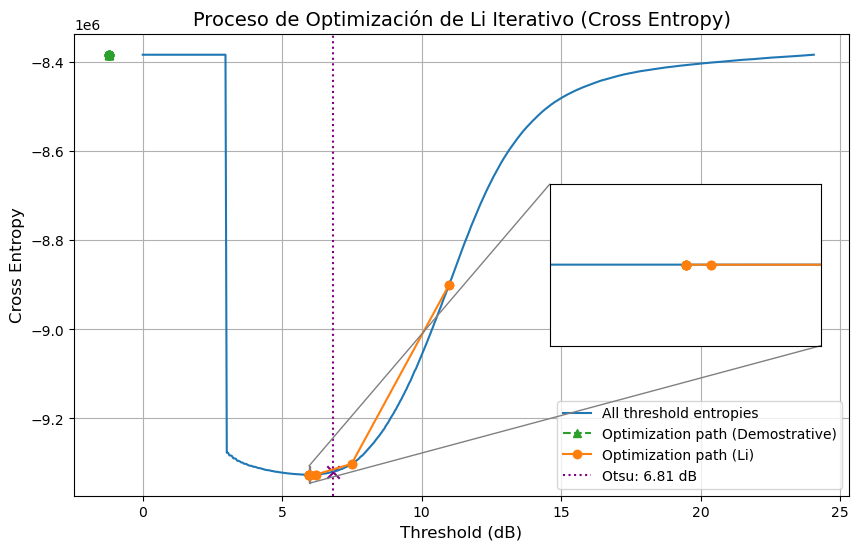

c:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\coastalcf\coastalcf\WDBThreshold.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc='lower left', fontsize=10)


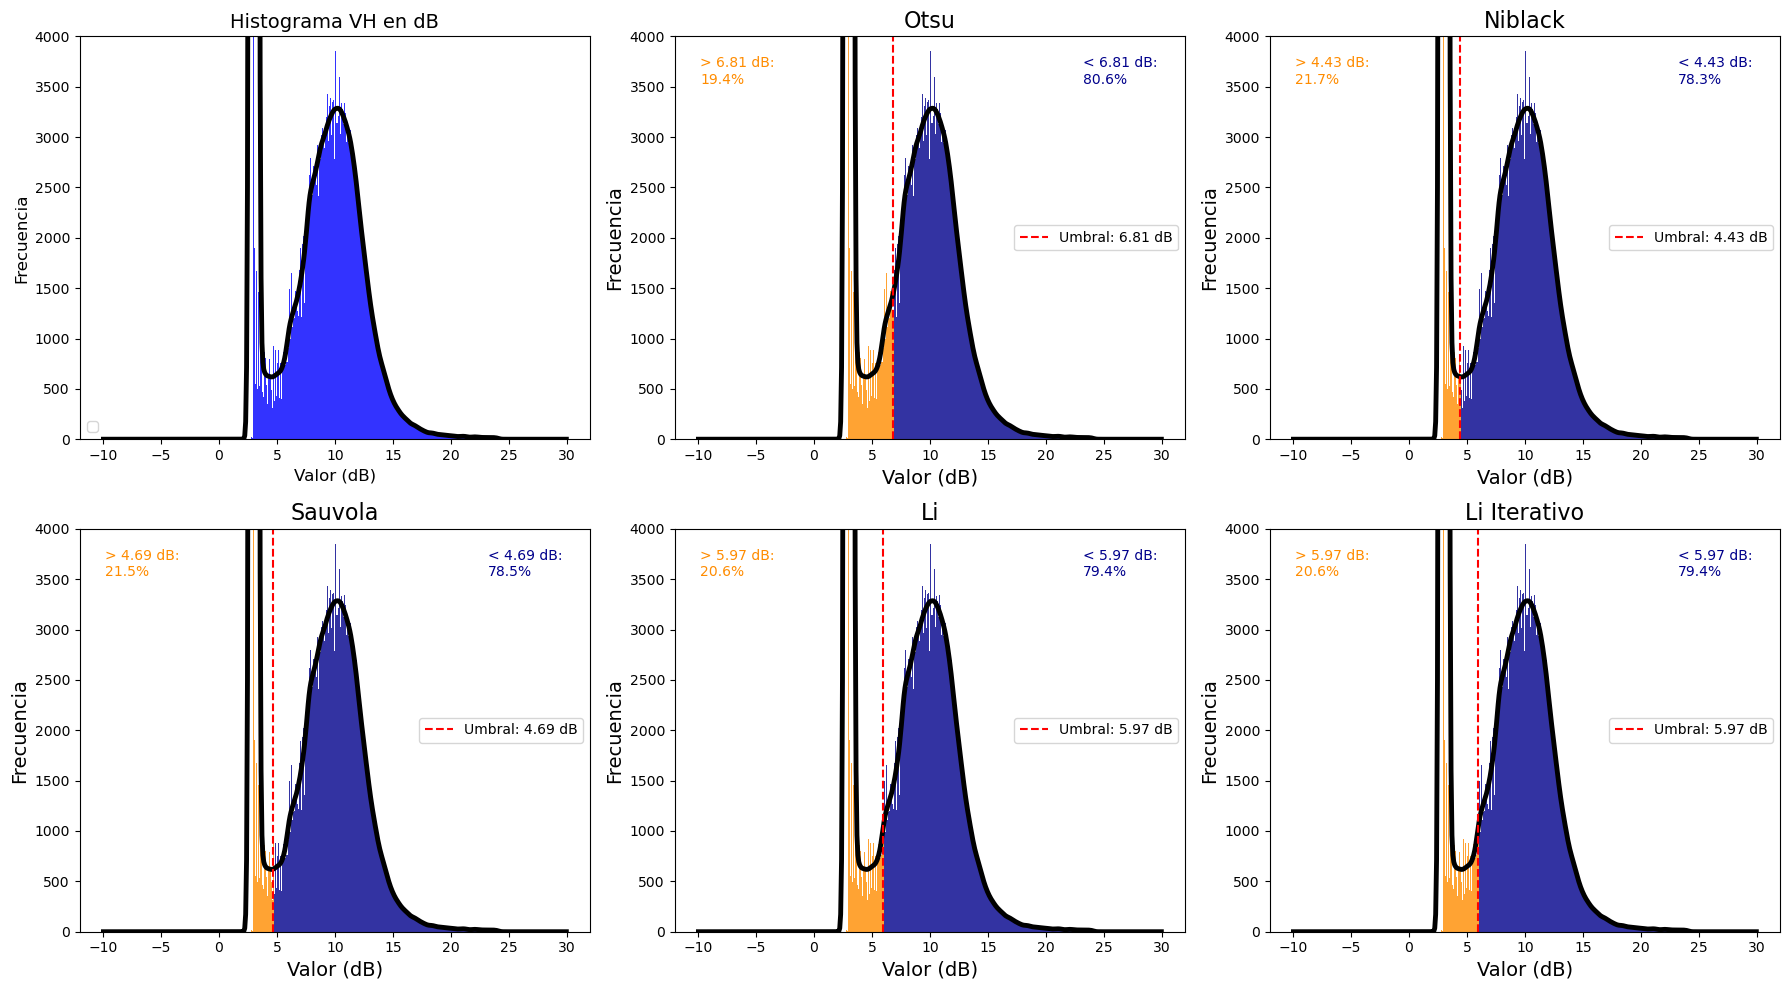

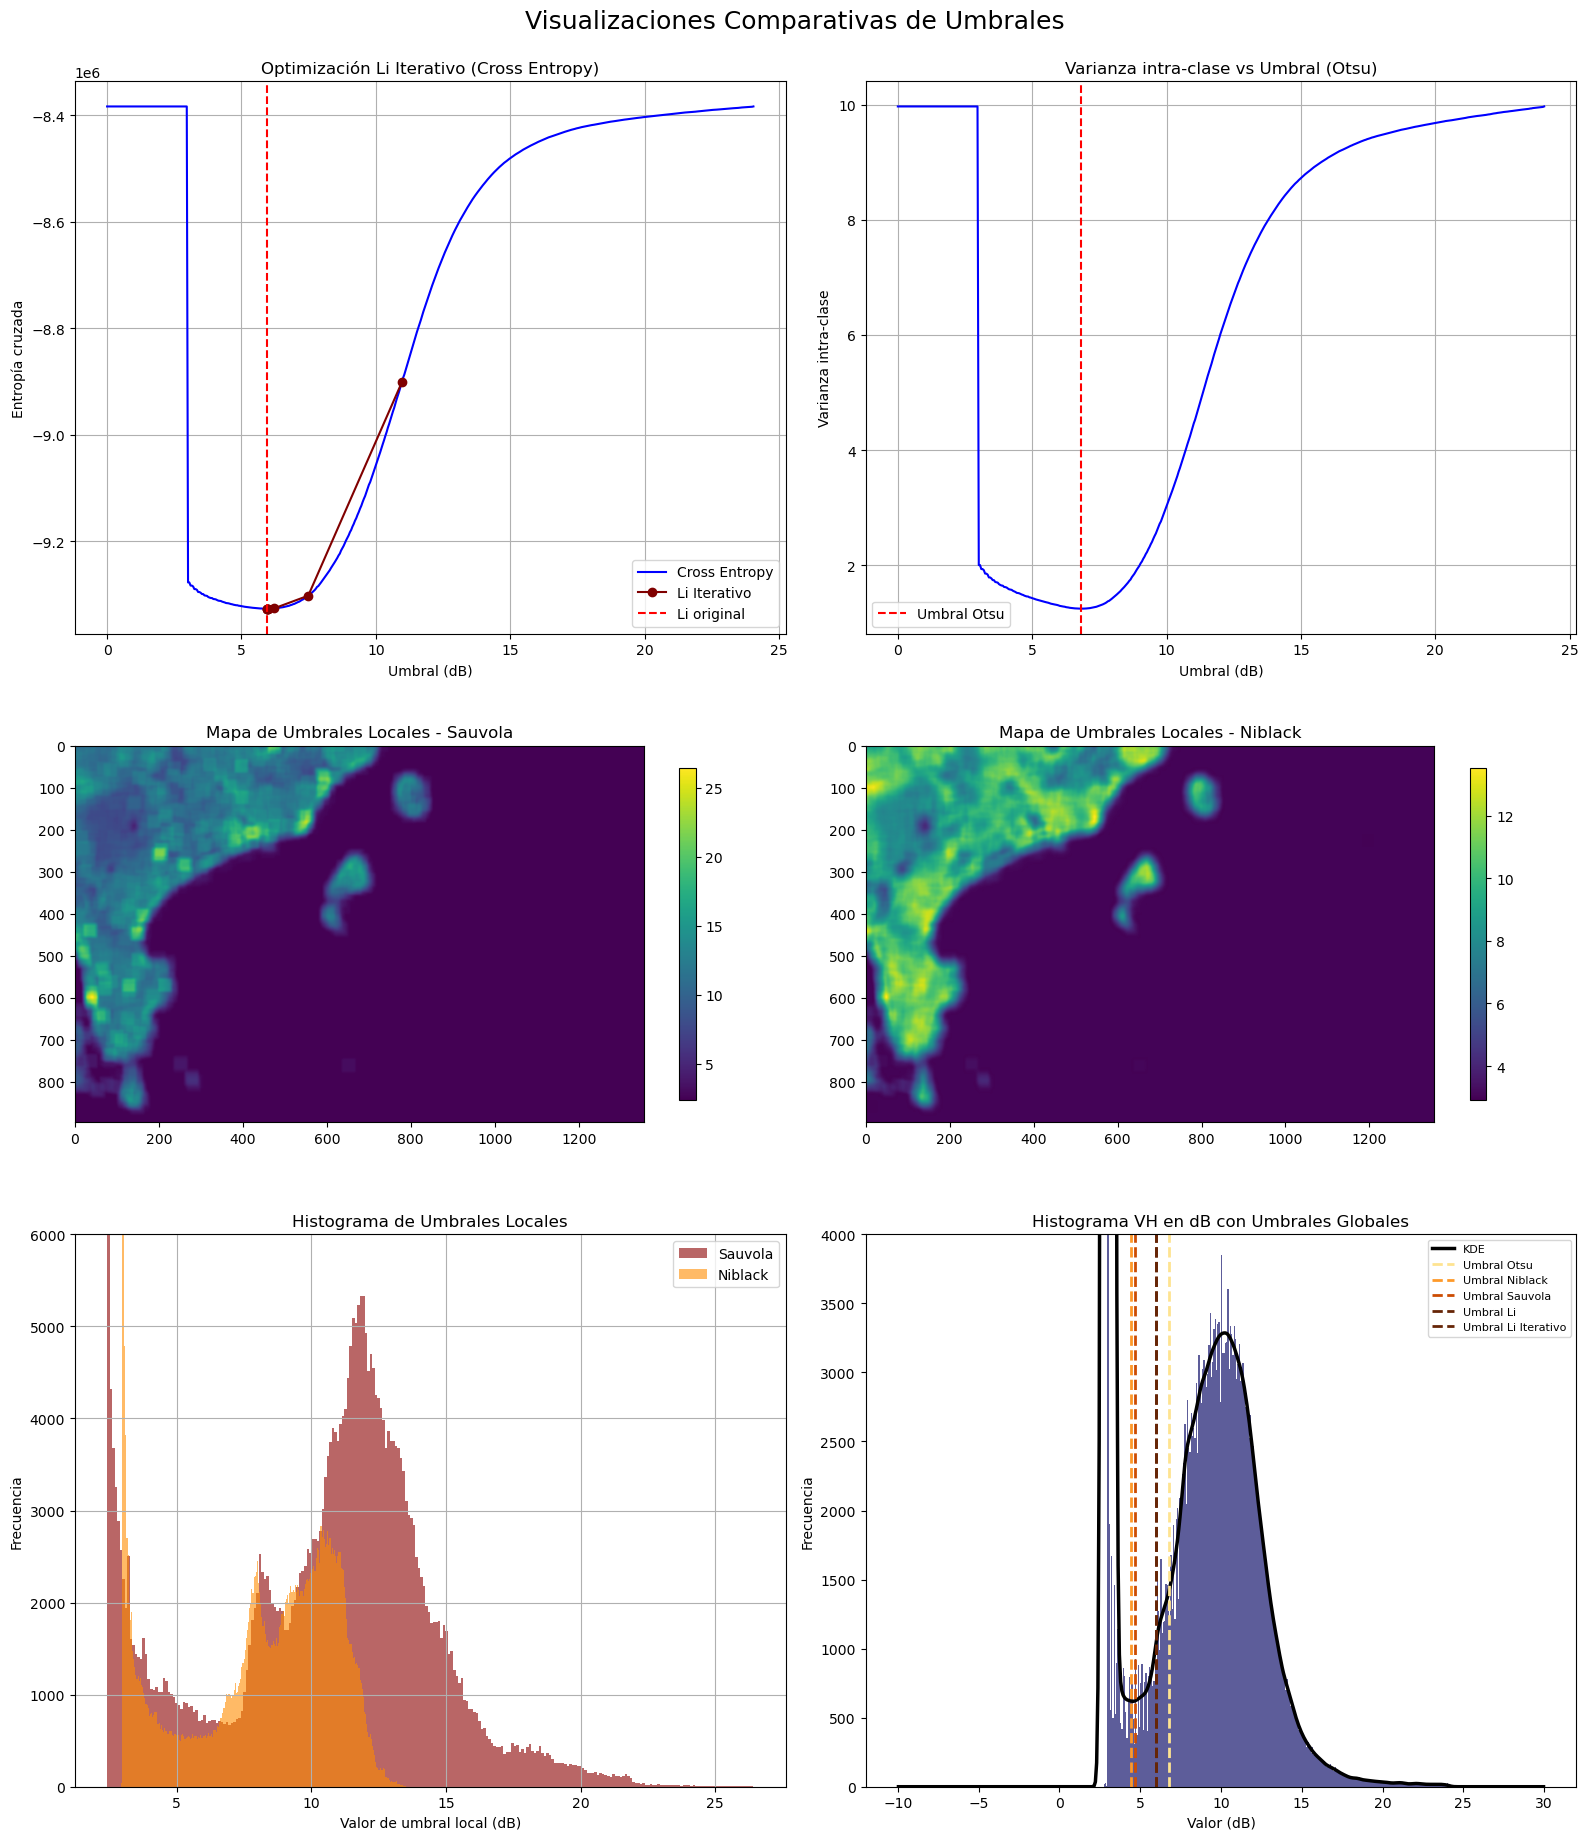

In [4]:
#**************************************************************************

# 8. Umbralización (Método Sauvola) : waterDetectionBinarization [product]
print("Performing water detection...")
productos_binarios, umbrales, img_db_valid = clf.WDBThreshold(
    textura=textura,
    sentinel_1_path=sentinel_1_path,
    window_size=31,
    k=0.2,     # extra param para Niblack/Sauvola
    r=None,     # extra param para Sauvola
    output_dir= output_directory
)

productos_para_graficar = {
    "flood_otsu": (productos_binarios["flood_otsu"], umbrales["otsu"]),
    "flood_niblack": (productos_binarios["flood_niblack"], umbrales["niblack"]),
    "flood_sauvola": (productos_binarios["flood_sauvola"], umbrales["sauvola"]),
    "flood_li": (productos_binarios["flood_li"], umbrales["li"]),
    "flood_li_iter": (productos_binarios["flood_li_iter"], umbrales["li_iterativo"]),
}
#**************************************************************************





In [ ]:
1=2

SyntaxError: cannot assign to literal (3293032332.py, line 1)

: 

Applying terrain correction to all thresholded products...
 -> Corrigiendo: flood_otsu

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_otsu' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_otsu_VH' con valor: -1.0
Bandas resultantes: ['flood_otsu_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_niblack

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_niblack' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_niblack_VH' con valor: -1.0
Bandas resultantes: ['flood_niblack_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_sauvola

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_sauvola' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asigna

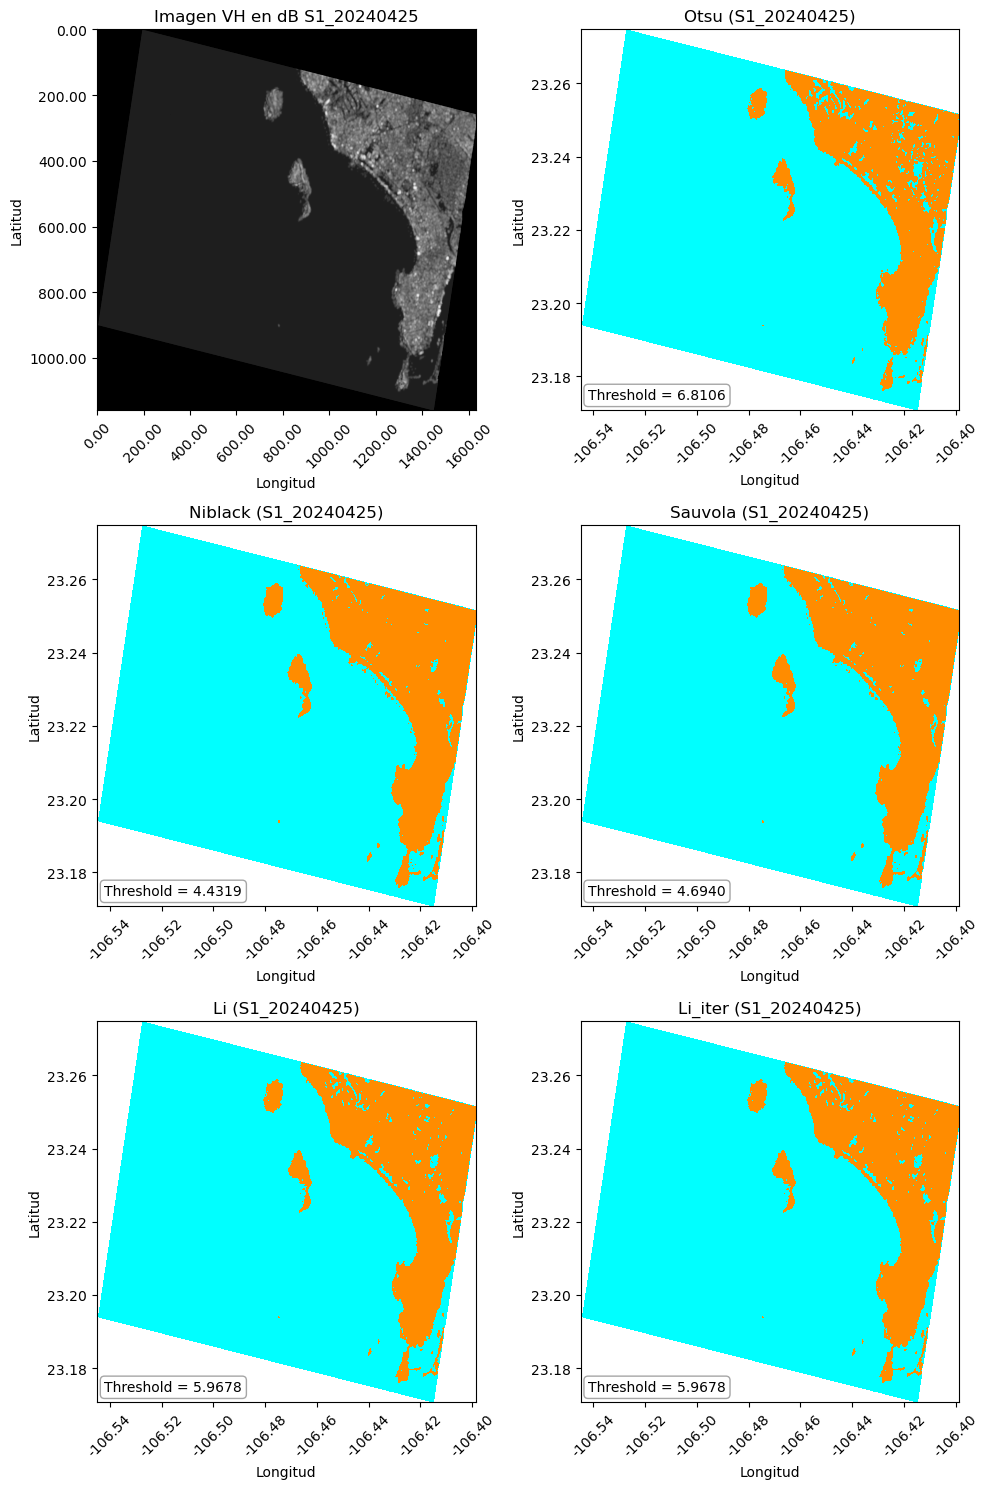

: 

: 

: 

: 

: 

: 

In [ ]:
#**************************************************************************


# 9. Corrección geométrica: geometricCorrection [corrected]

print("Applying terrain correction to all thresholded products...")

productos_binarios_corrected = {}
for nombre, (producto, threshold) in productos_para_graficar.items():
    print(f" -> Corrigiendo: {nombre}")
    corregido = clf.geometricCorrection(producto, toPrint=True)
    if corregido is None:
        print(f"⚠️  No se pudo corregir el producto: {nombre}")
    else:
        productos_binarios_corrected[nombre] = (corregido, threshold)

img_db_product = clf.geometricCorrection(img_db_valid, toPrint=True)


# 10. Visualización en grid de productos corregidosprint("\nCreando producto SNAP para img_db_valid...")

from coastalcf.wbplots import aplicar_correccion_y_grid
#aplicar_correccion_y_grid(productos_binarios_corrected, output_directory, sentinel_id)
aplicar_correccion_y_grid(
    productos_binarios=productos_binarios_corrected, 
    output_directory=output_directory,
    sentinel_id="S1_20240425",
    img_db_product=img_db_product#,  # <- tu imagen VH ya en dB
    #vh_extent=[lon_min, lon_max, lat_min, lat_max]  # <- opcional si quieres respetar georeferencia
    )


Método: flood_otsu
Bandas disponibles: ['flood_otsu_VH']
Buscando la banda: flood_otsu_VH


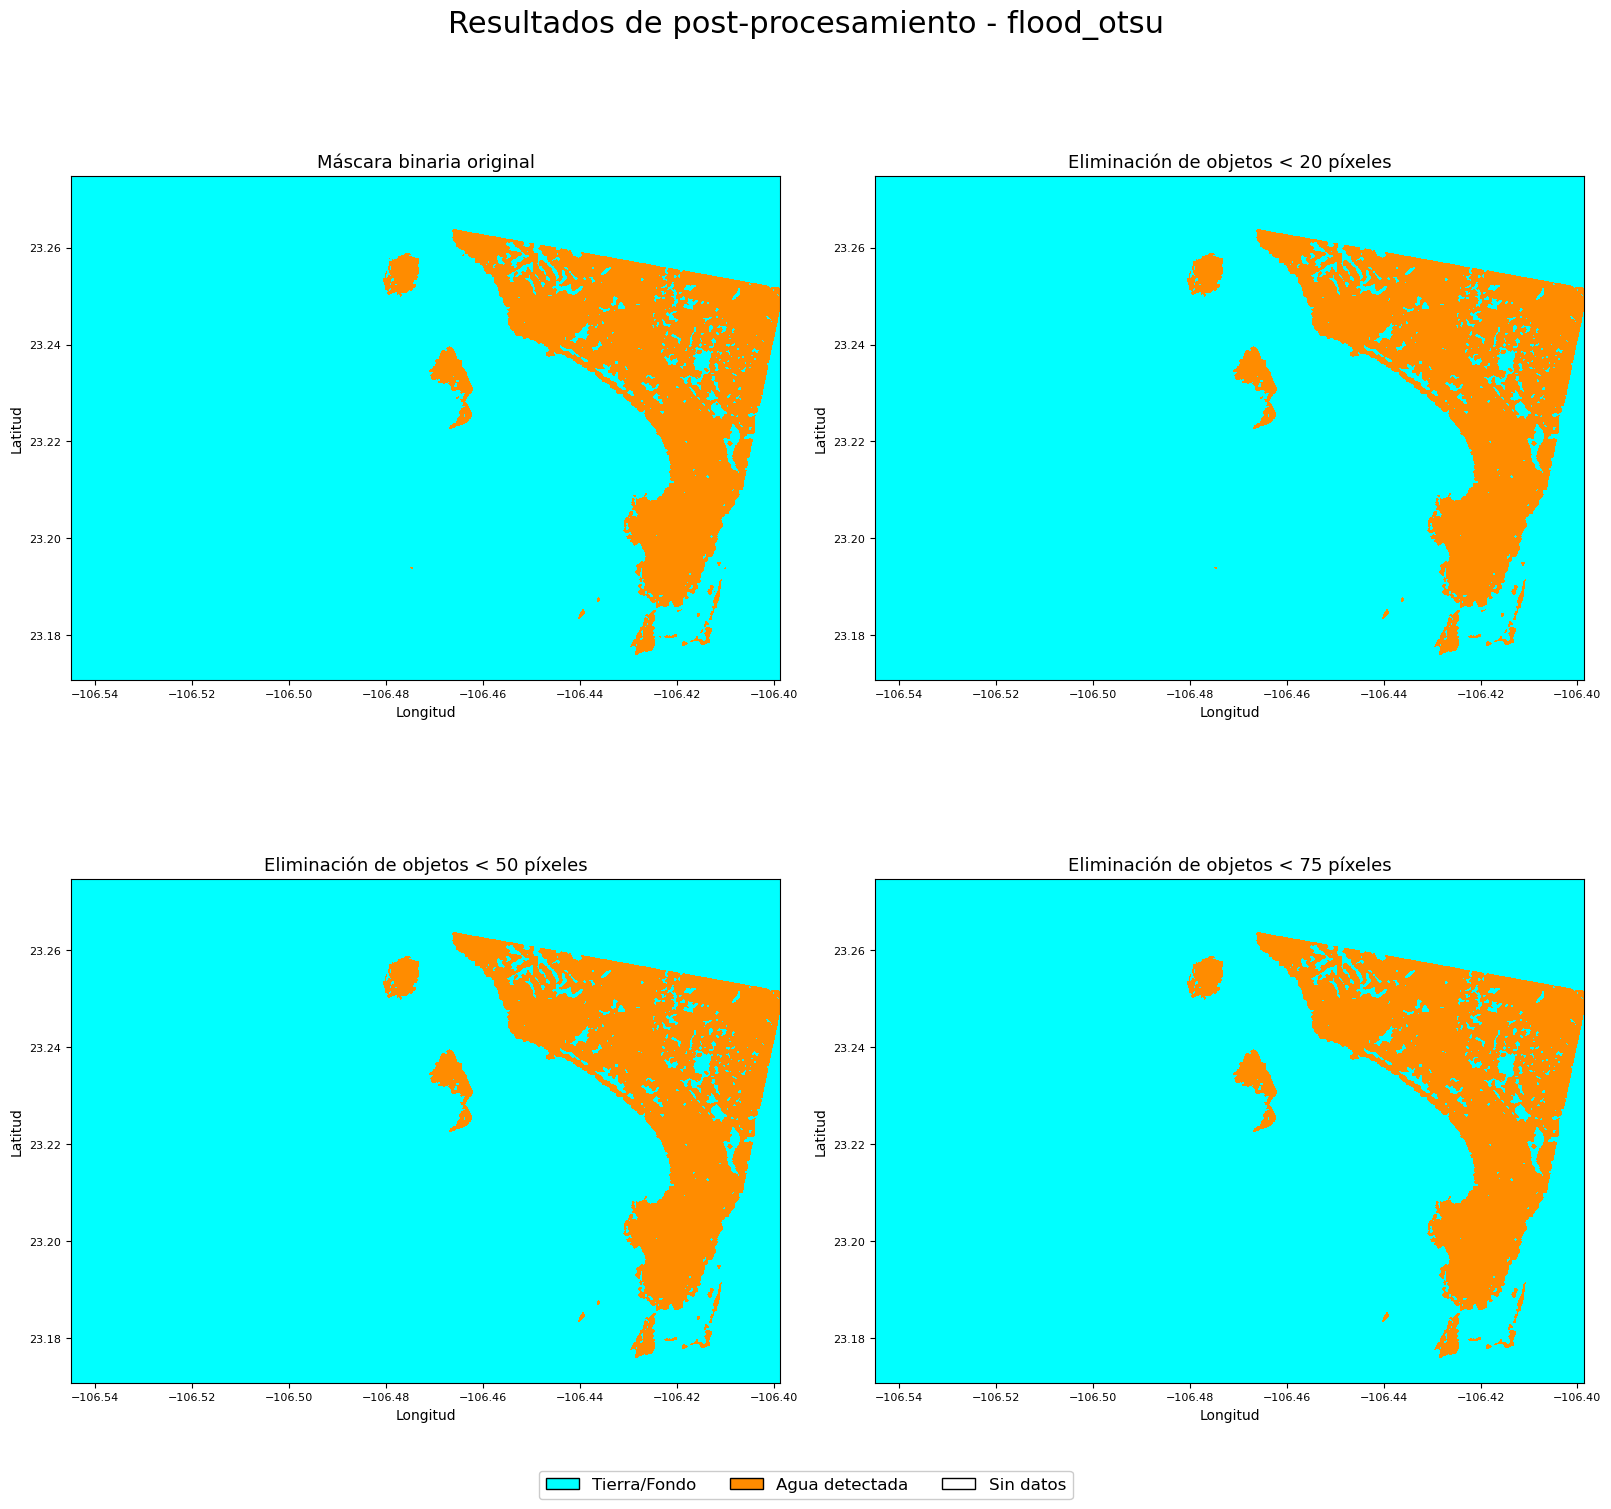


Método: flood_niblack
Bandas disponibles: ['flood_niblack_VH']
Buscando la banda: flood_niblack_VH


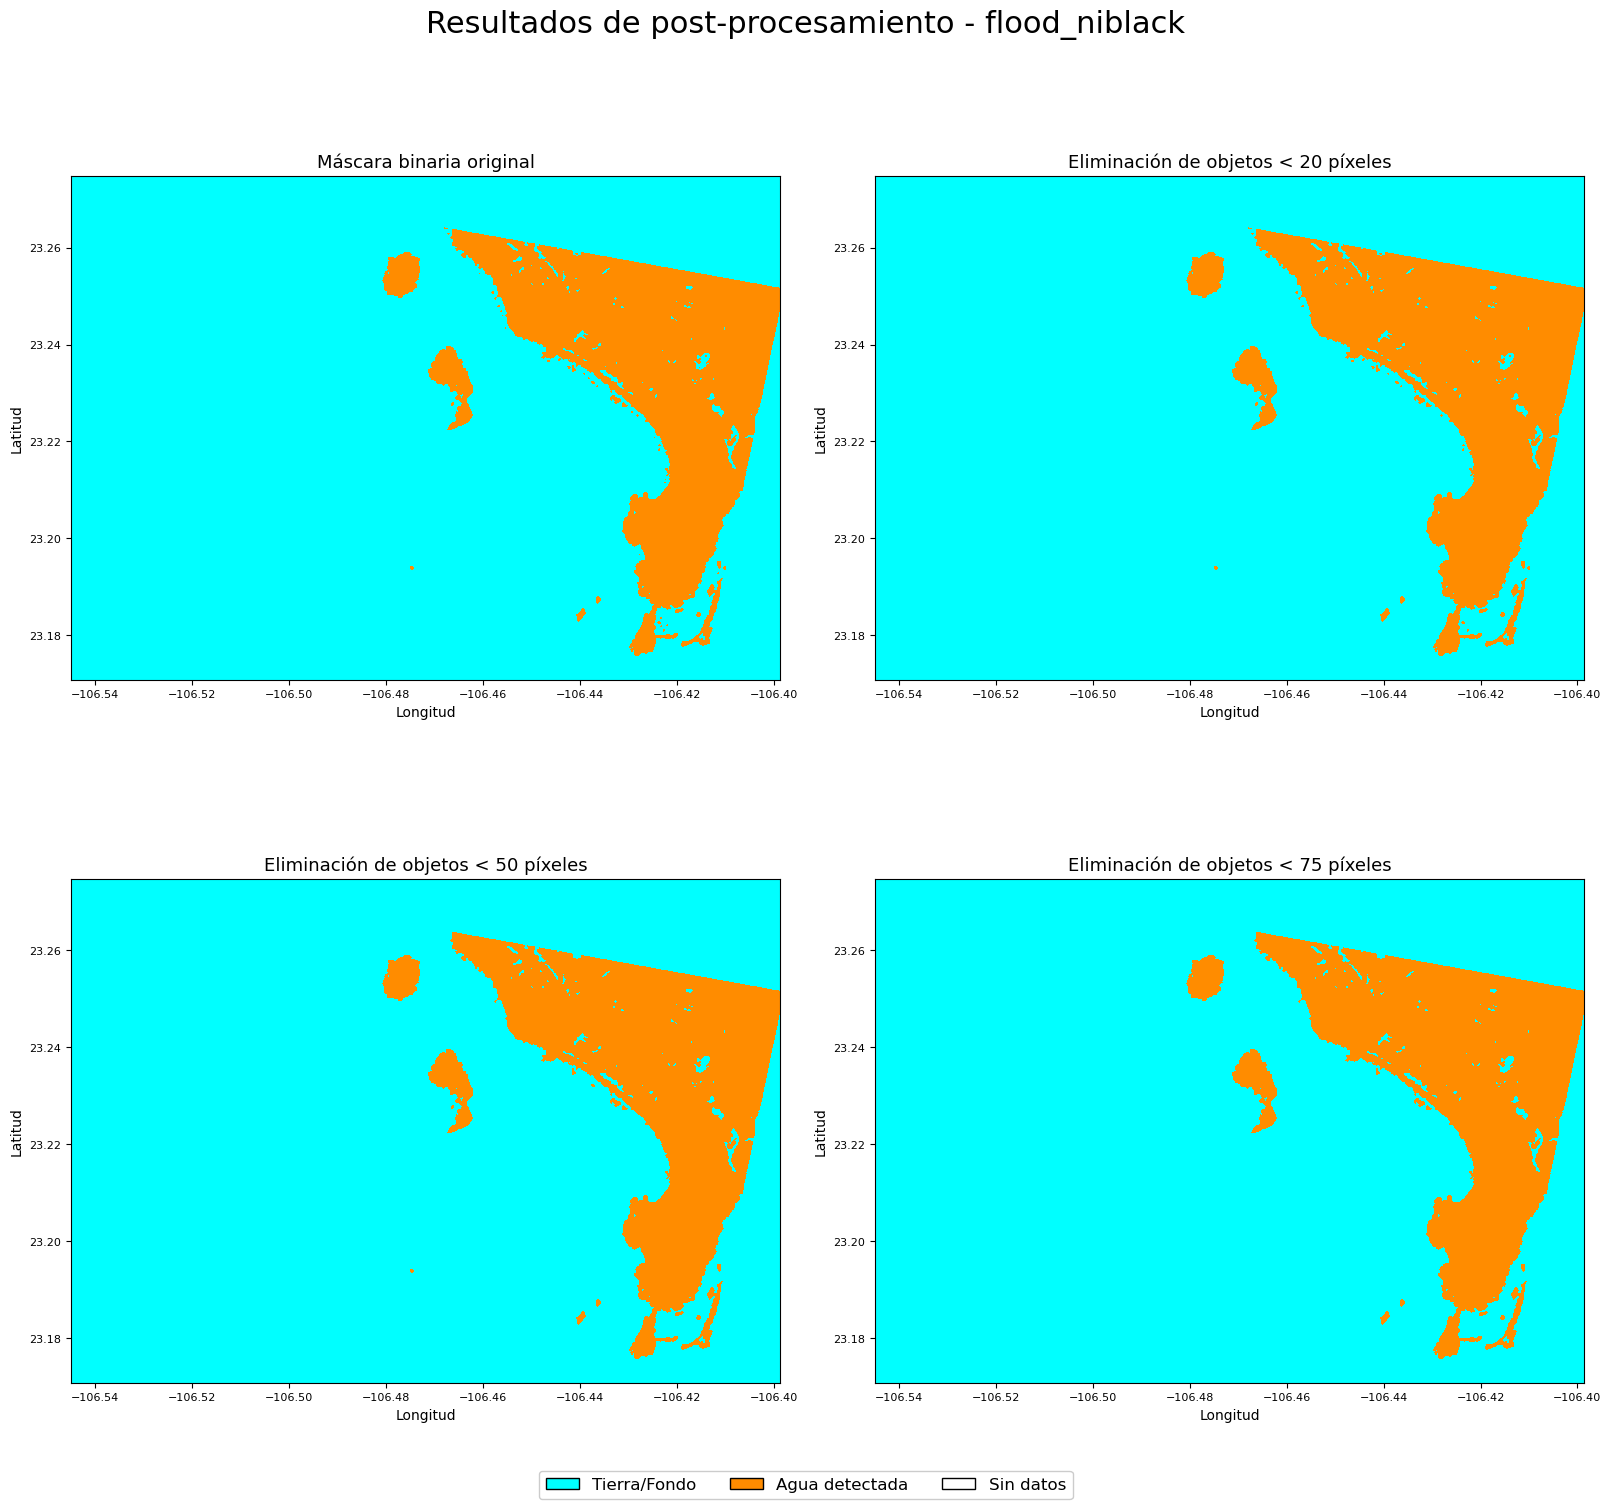


Método: flood_sauvola
Bandas disponibles: ['flood_sauvola_VH']
Buscando la banda: flood_sauvola_VH


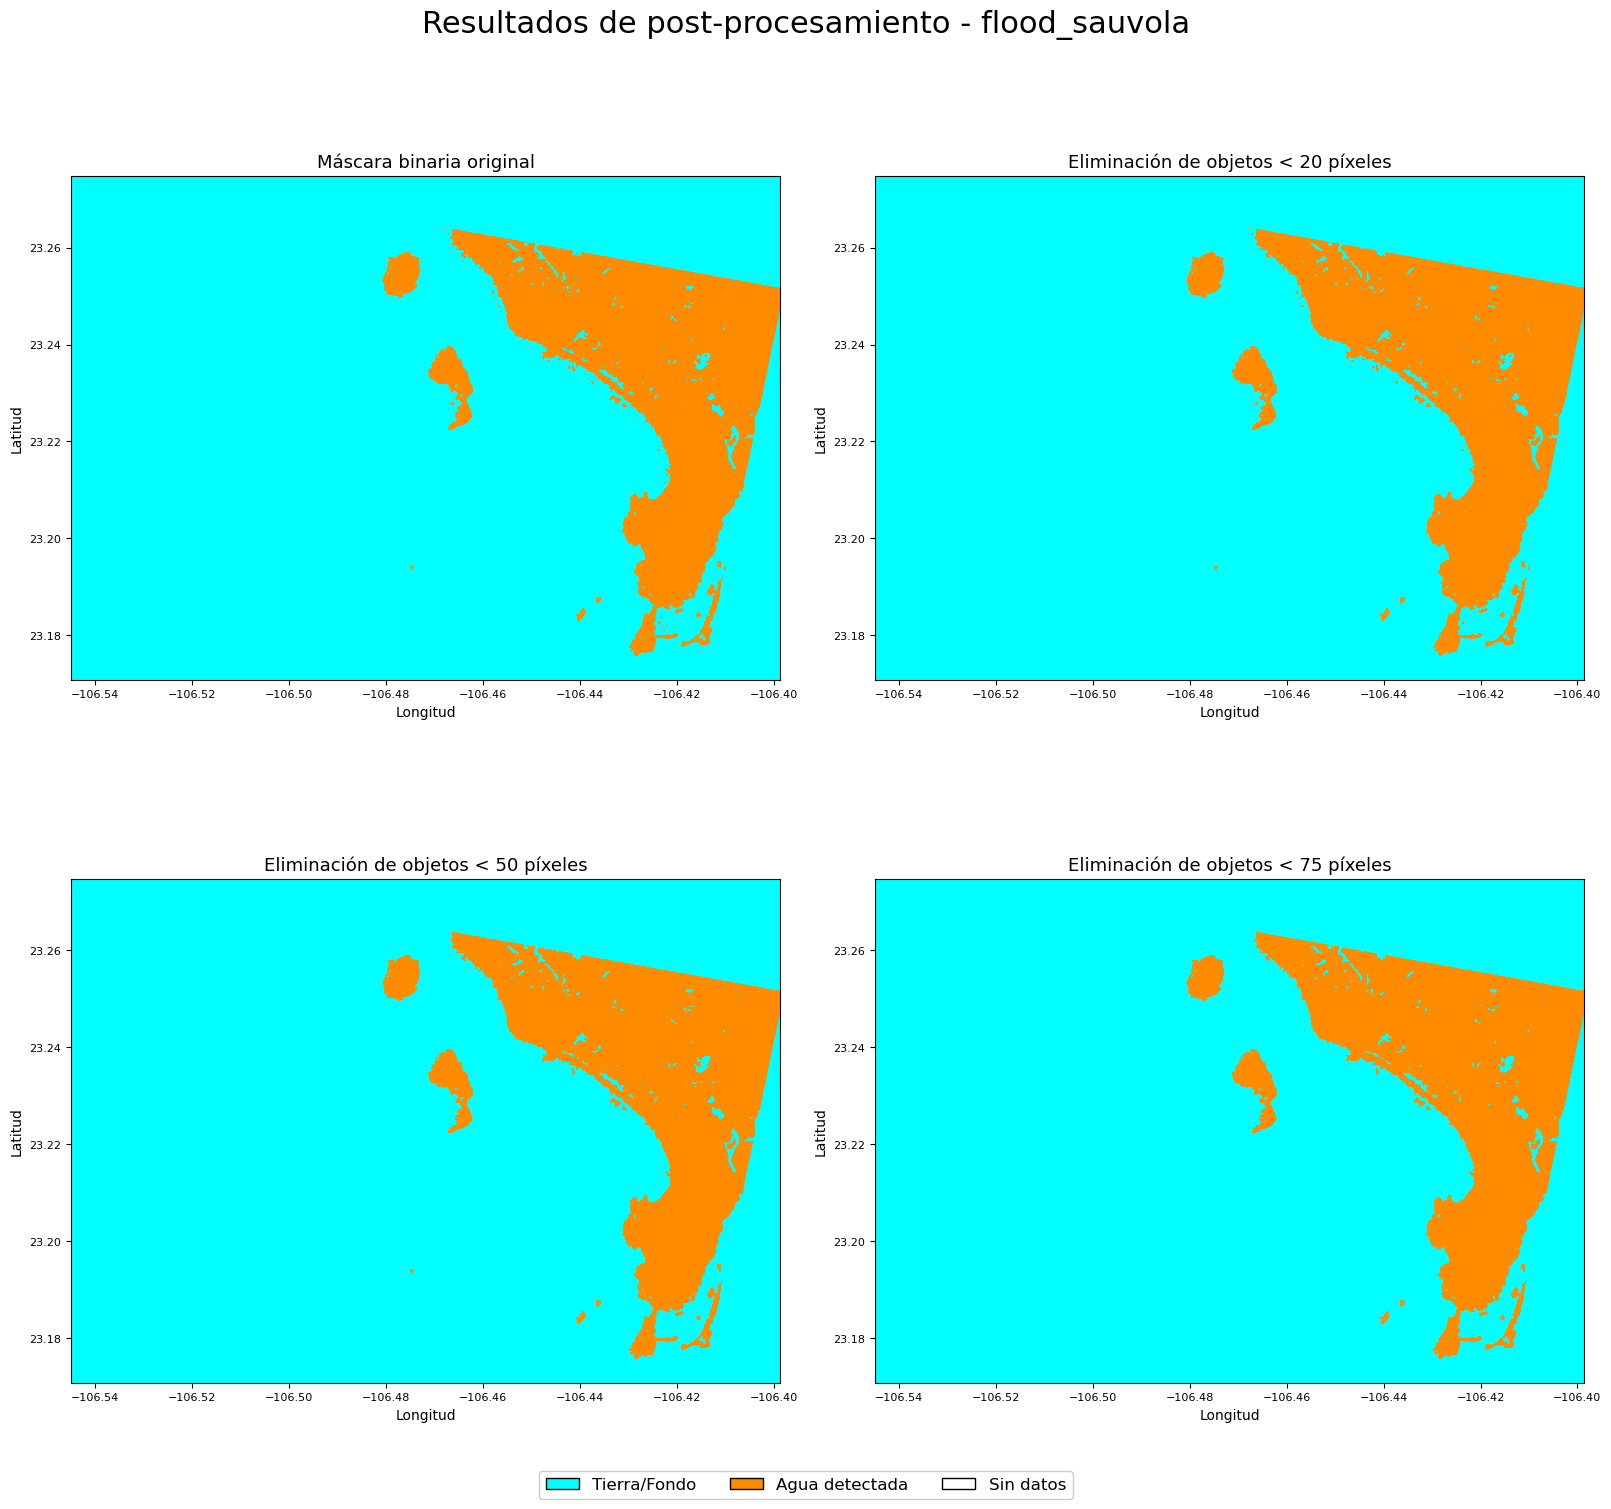


Método: flood_li
Bandas disponibles: ['flood_li_VH']
Buscando la banda: flood_li_VH


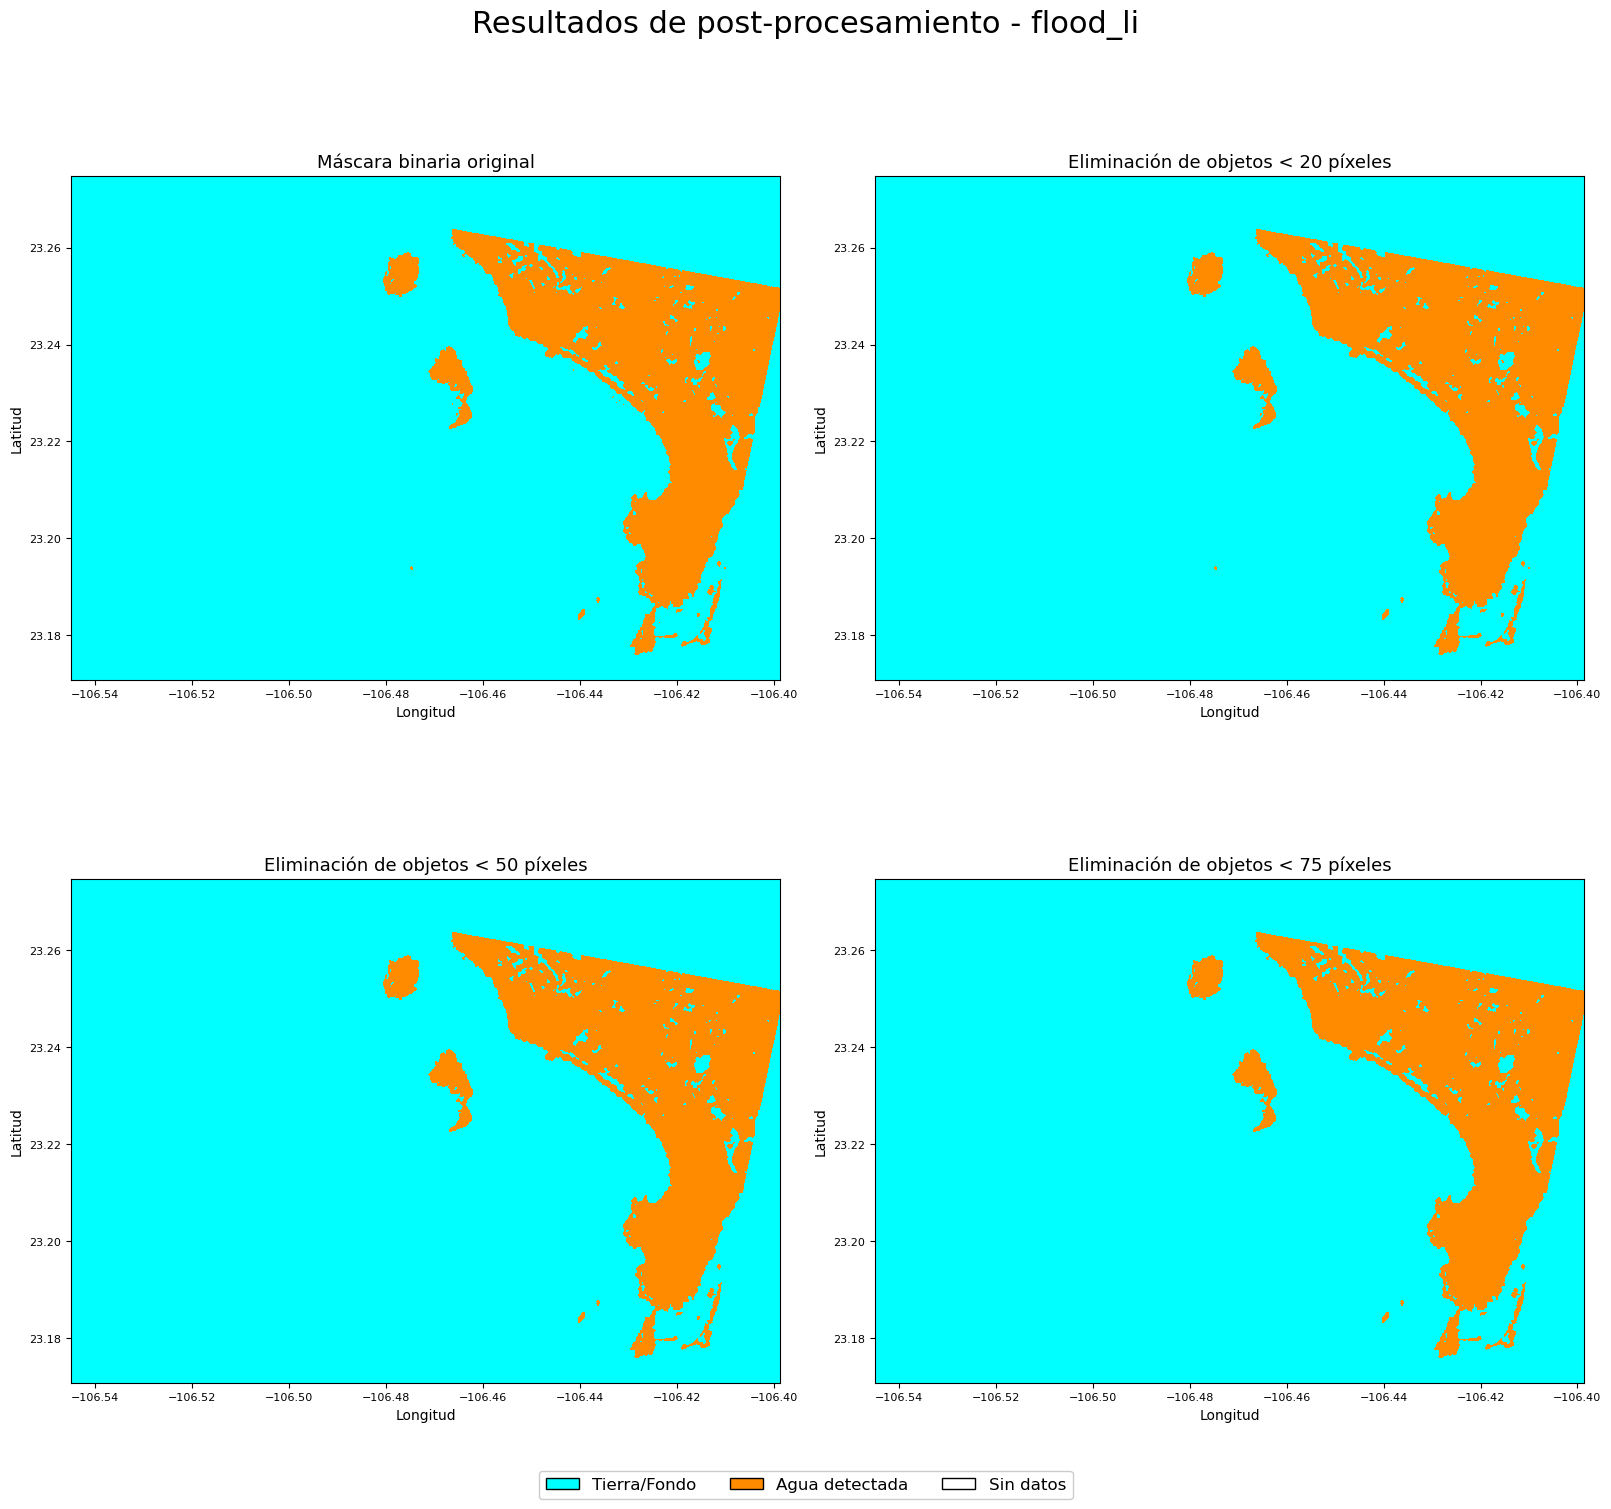


Método: flood_li_iter
Bandas disponibles: ['flood_li_iter_VH']
Buscando la banda: flood_li_iter_VH


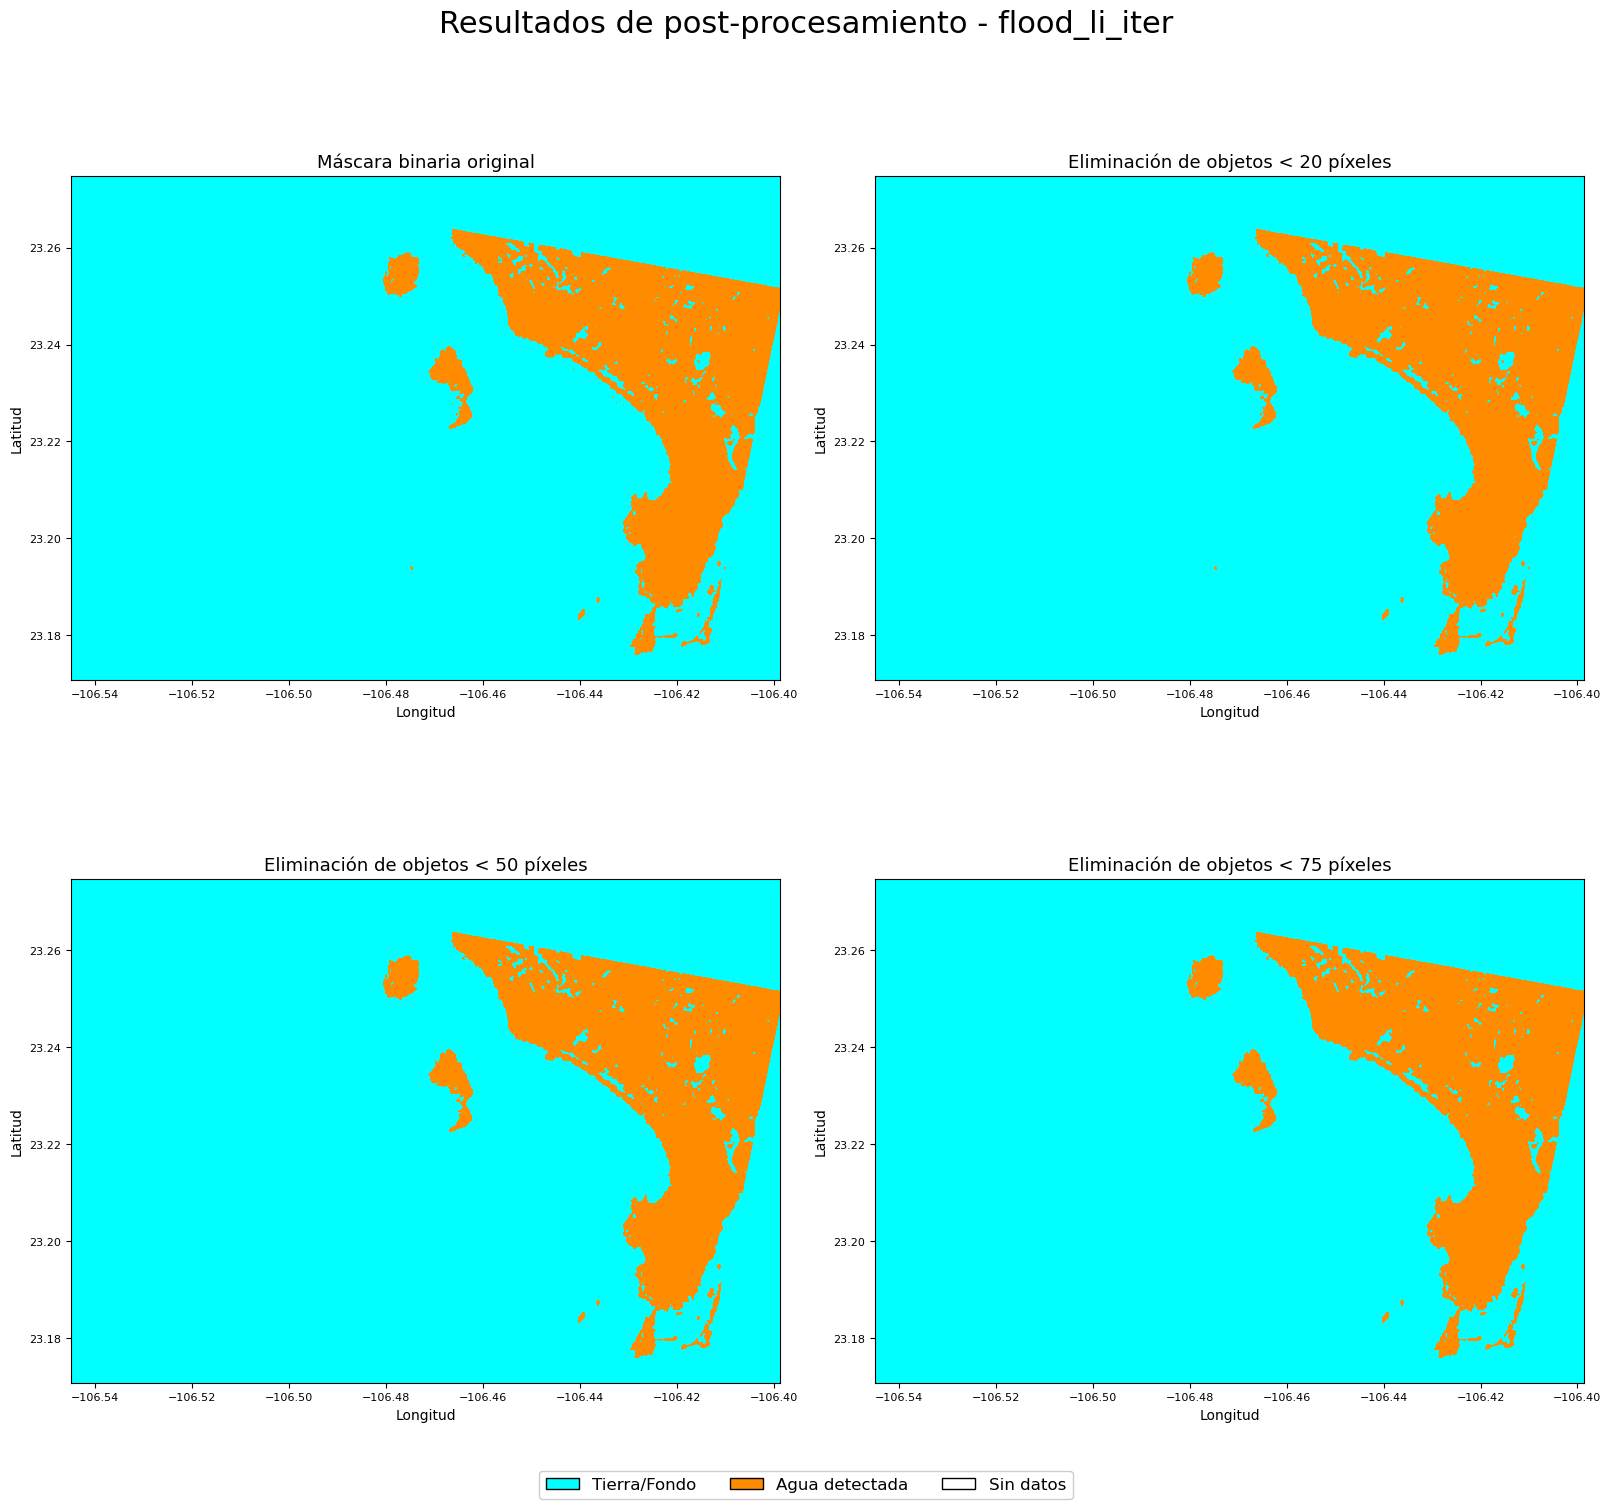

: 

: 

: 

: 

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage.morphology import remove_small_objects
from esa_snappy import jpy, GeoPos, PixelPos

# Crear colormap personalizado: False -> Cyan, True -> Dark Orange
custom_cmap = ListedColormap(["#00FFFF", "#FF8C00"])
custom_cmap.set_bad(color='white')

def plot_image(ax, image, title='', extent=None):
    im = ax.imshow(image.astype(float), cmap=custom_cmap, vmin=0, vmax=1, extent=extent)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_aspect('equal')  # Forzar que sea cuadrado
    return im

# Crear la leyenda personalizada
legend_elements = [
    Patch(facecolor='#00FFFF', edgecolor='k', label='Tierra/Fondo'),
    Patch(facecolor='#FF8C00', edgecolor='k', label='Agua detectada'),
    Patch(facecolor='white', edgecolor='k', label='Sin datos')
]

# Tamaños a eliminar
object_sizes = [20, 50, 75]

# Procesar cada método
for nombre_metodo, (producto_corregido, threshold) in productos_binarios_corrected.items():
    print(f"\nMétodo: {nombre_metodo}")
    band_name = f'{nombre_metodo}_VH'

    print(f"Bandas disponibles:", list(producto_corregido.getBandNames()))
    print(f"Buscando la banda:", band_name)

    band = producto_corregido.getBand(band_name)
    width = band.getRasterWidth()
    height = band.getRasterHeight()

    # Leer datos
    data = np.zeros((height, width), dtype=np.float32)
    band.readPixels(0, 0, width, height, data)
    data[data == -1.0] = np.nan  # NoData como NaN

    # ⚡️ No eliminar NaN
    imagen_binaria = data.astype(float)
    imagen_binaria = np.where(imagen_binaria > 0.5, 1, 0)

    # Obtener coordenadas reales para extent
    try:
        geo = producto_corregido.getSceneGeoCoding()
        upper_left = GeoPos()
        lower_right = GeoPos()
        geo.getGeoPos(PixelPos(0, 0), upper_left)
        geo.getGeoPos(PixelPos(width - 1, height - 1), lower_right)

        lon_0, lat_0 = upper_left.lon, upper_left.lat
        lon_w, lat_h = lower_right.lon, lower_right.lat
        extent = [lon_0, lon_w, lat_h, lat_0]
    except Exception as e:
        print(f"⚠️ No se pudo obtener geo-referencias para {nombre_metodo}: {e}")
        extent = None

    # Crear figura
    fig, axs = plt.subplots(2, 2, figsize=(16, 14), constrained_layout=True)
    axs = axs.flatten()

    # Graficar original
    plot_image(axs[0], imagen_binaria, title='Máscara binaria original', extent=extent)

    # Aplicar remove_small_objects con diferentes tamaños
    for i, osz in enumerate(object_sizes):
        imagen_filtrada = remove_small_objects(imagen_binaria.astype(bool), osz, connectivity=1)
        plot_image(axs[i+1], imagen_filtrada, title=f'Eliminación de objetos < {osz} píxeles', extent=extent)

    # Agregar leyenda en la figura (no en cada subplot)
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12, frameon=True, framealpha=1, fancybox=True, bbox_to_anchor=(0.5, -0.02))

    fig.suptitle(f'Resultados de post-procesamiento - {nombre_metodo}', fontsize=22, y=1.05)
    plt.savefig(os.path.join(output_directory, f'{nombre_metodo}_post_procesamiento.png'), dpi=300, bbox_inches='tight')
    plt.show()



: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_img_db_valid(img_db_valid, sentinel_id="", extent=None, output_dir=None):
    """
    Grafica una imagen en dB (img_db_valid) usando escala de 0 a 25 dB,
    con ejes de latitud y longitud opcionales si se proporciona el extent.
    
    Args:
        img_db_valid (np.ndarray): Imagen en dB.
        sentinel_id (str): ID del producto Sentinel (opcional, para título).
        extent (list or tuple): [left, right, bottom, top] para georreferenciar.
        output_dir (str): Carpeta donde guardar el plot (opcional).
    """
    # --- Voltear para que el norte esté arriba ---
    img_db_valid = np.fliplr(img_db_valid)

    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(img_db_valid, cmap='gray', vmin=0, vmax=25,
                   extent=extent if extent else None, aspect='auto')

    ax.set_title(f'Imagen VH en dB {sentinel_id}', fontsize=14)
    ax.set_xlabel('Longitud', fontsize=12)
    ax.set_ylabel('Latitud', fontsize=12)

    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Si hay extent, ajustar límites de los ejes
    if extent:
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Valor (dB)', fontsize=12)

    fig.tight_layout()

    # Guardar si se pide
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{sentinel_id}_img_db_valid_plot.png"), dpi=300)

    plt.show()
    plt.close()
    
plot_img_db_valid(img_db_valid, sentinel_id="S1B_20230415", extent=[-106.49, -106.41, 23.13, 23.265], output_dir="plots")


ValueError: Input must be >= 2-d.

: 

: 

: 

: 

: 

ValueError: num must be an integer with 1 <= num <= 4, not 5

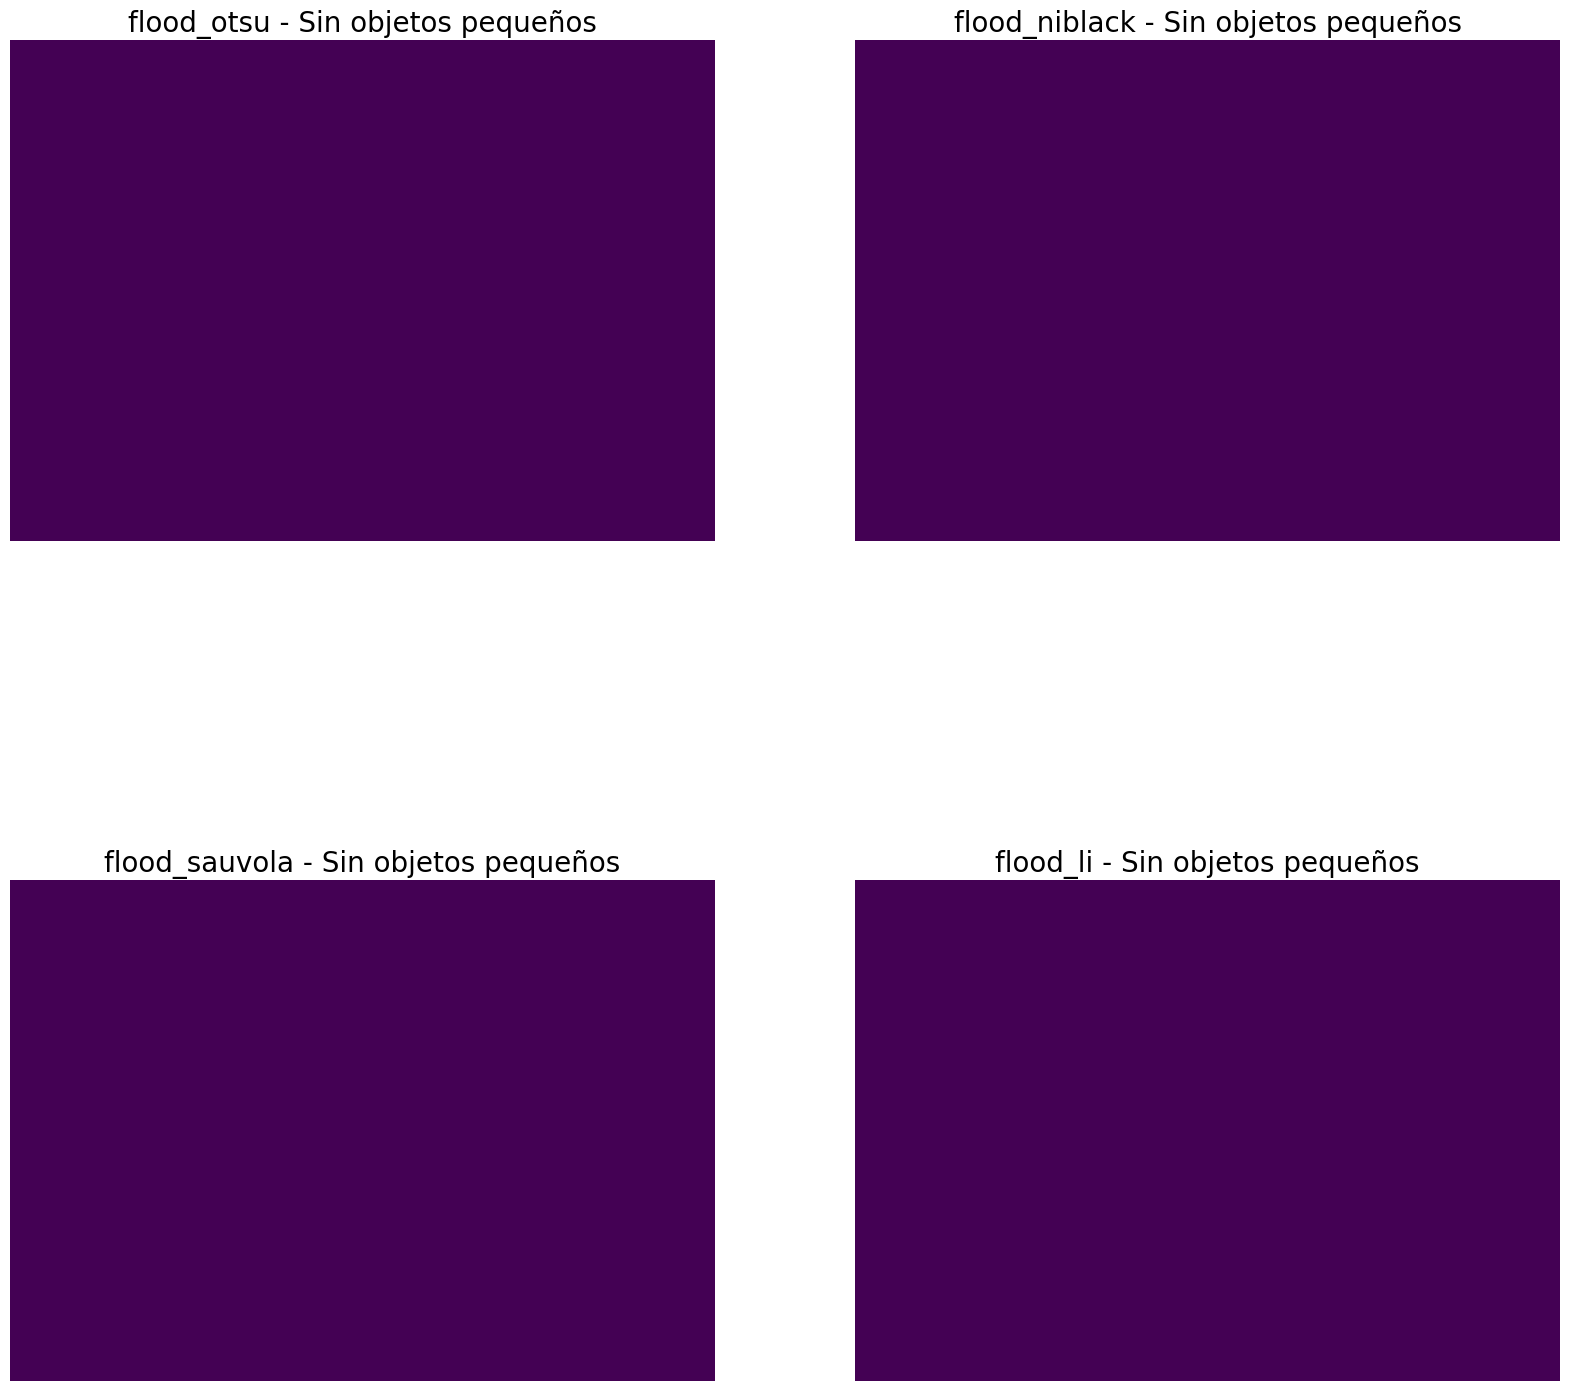

: 

: 

: 

: 

: 

In [ ]:

"""
##---------------------------------------
# 1) Abrir el GeoTIFF en modo solo-lectura
tif_path = final_tif
ds = gdal.Open(tif_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)

# 2) Leer la banda a un array float32
glcm = band.ReadAsArray().astype(np.float32)

# 3) Manejar NoData → NaN
nodata = band.GetNoDataValue()      # debería devolver -9999.0
if nodata is not None:
    glcm[glcm == nodata] = np.nan   # así tu histograma ignora nodata

# 4) ¡Listo!  →  Llamar a la función
thresholds, scores = histograma_threshold_metrics(glcm)
#---------------------------------------------------------
    
for nombre, producto in productos_binarios_corrected.items():
    # Generar sufijos personalizados para cada nombre de producto
    suffix_base = f"_{nombre}_corrected"

    # Generar rutas de salida usando tus funciones reutilizables
    raster_path = clf.generate_raster_path(sentinel_1_path, output_directory)
    shapefile_path = clf.generate_shapefile_path(sentinel_1_path, output_directory)

    print(f"Procesando producto corregido: {nombre}")
    
    # Exportar raster y shapefile
    #clf.exportar_raster_y_shapefile(producto, raster_path, shapefile_path)
"""


"""
for nombre, producto in productos_binarios_corrected.items():
    output_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.tif")  
    shape_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.shp")  
    print(f"Guardando producto corregido: {output_path}")
    #ProductIO.writeProduct(producto, output_path, "GeoTIFF")  # o "GeoTIFF" si prefieres tif
"""
#extent=[-106.52, -106.41, 23.17, 23.27]
